### Екип
Рая Симеонова - 62557  
Надя Катевска - 250 

### Проект
   
Тип на проекта: А  
Название на проекта: San Francisco Crime Classification

#### Описание на данните (EDA)

В dataset-а се срещат следните характеристики на данните:

- Dates - дата и час на престъплението
- Category - категория на престъплението (само в train.csv). Таргет променливата, която трябва да се предвиди.
- Descript - подробно описание на престъплението (само в train.csv)
- DayOfWeek - денят в седмицата
- PdDistrict - името на районното полицейско управление
- Resolution - как престъплението е разрешено (само в train.csv)
- Address - приблизителния адрес на престъплението 
- X - географска дължина
- Y - географска щирина

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import holidays

# Load the dataset
data = pd.read_csv('sf-crime/train.csv')
test_data = pd.read_csv('sf-crime/test.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Id          884262 non-null  int64  
 1   Dates       884262 non-null  object 
 2   DayOfWeek   884262 non-null  object 
 3   PdDistrict  884262 non-null  object 
 4   Address     884262 non-null  object 
 5   X           884262 non-null  float64
 6   Y           884262 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47.2+ MB


Train set-а съдържа 9 характеристики, 3 от които (Category, Descript, Resolution) не са включени в test set-a, предоставен от Kaggle.  
Липсата на Descript и Resolution показва, че не се взимат под внимание при определянето на категория, а по-скоро са доуточняващи, затова могат да се премахнат при обработката на данните.  
Липсата на Category характеристика в test set-а показва, че няма да може да се използва, за тестване на модела преди предаването на резултатите от него в Kaggle, затова може да затворим този data frame и ще работим само с train set-a.

In [2]:
del test_data

In [6]:
data.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

Вижда се, че няма липсващи стойности за никоя от характеристиките.

Данните изглеждат по-този начин.

In [7]:
data.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414


Dates колоната може да се парсне и да се извлекат данните за година, месец, ден, час поотделно, така може да се види дали има някаква зависимост между отделните компоненти и категорията на престъплението

In [3]:
data['Dates'] = pd.to_datetime(data['Dates'], format='%Y-%m-%d %H:%M:%S')
data['Year'] = data['Dates'].dt.year
data['Month'] = data['Dates'].dt.month
data['Day'] = data['Dates'].dt.day
data['Hour'] = data['Dates'].dt.hour
data['Minute'] = data['Dates'].dt.minute

In [9]:
data.head(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,Hour,Minute
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,53
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23,33
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23,30
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23,30


Нека дефинираме помощни функции, които да използваме за plot-ването на разпределенията на различните характеристики.

In [10]:
def plot_bar(label, fig_num, isChronological=False):
    plt.figure(figsize=(15, 8))

    if isChronological:
        data[label].value_counts().sort_index().plot(kind='bar', color='darkslategray')
    else:
        data[label].value_counts().plot(kind='bar', color='darkslategray')

    plt.title(f'Fig. {fig_num} Distribution of Crimes per {label}')
    plt.xlabel(label)
    plt.ylabel('Number of Crimes')
    plt.show()

In [11]:
def plot_line(label, fig_num, categories_count=5):
    # Group by label and find the count for each category
    category_counts_per_label = data.groupby([label, 'Category']).size().reset_index(name='Count')

    # Get the top 5 categories overall
    top_categories = category_counts_per_label.groupby('Category')['Count'].sum().nlargest(categories_count).index
    # top_categories = category_counts_per_label['Category'].sample(n=5, replace=False, random_state=20)
    # Create a single figure for the hour line graph
    plt.figure(figsize=(12, 8))

    # Plot lines for each top category with different colors
    for i, category in enumerate(top_categories):
        subset = category_counts_per_label[category_counts_per_label['Category'] == category]
        plt.plot(subset[label], subset['Count'], marker='o', label=category)

    # Set plot properties for the hour line graph
    plt.title(f'Fig. {fig_num}: Count of Top Categories Across {label}s')
    plt.xlabel(label)
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
def barplot_with_hue(label):
    label_category_counts = data.groupby([label, 'Category']).size().reset_index(name='Count')

    # Get the 8 most common categories
    top_categories = label_category_counts.groupby('Category')['Count'].sum().nlargest(8).index

    # Filter the data for the top categories
    label_category_counts_top8 = label_category_counts[label_category_counts['Category'].isin(top_categories)]

    # Set the plotting style
    sns.set(style="whitegrid")

    # Create a bar plot with hue (color) for each category
    plt.figure(figsize=(14, 8))
    sns.barplot(x=label, y='Count', hue='Category', data=label_category_counts_top8, palette='viridis')
    plt.title(f'8 Most Common Categories per {label} with Hue for Each Category')
    plt.xlabel(label)
    plt.ylabel('Count')
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place the legend outside the plot
    plt.show()

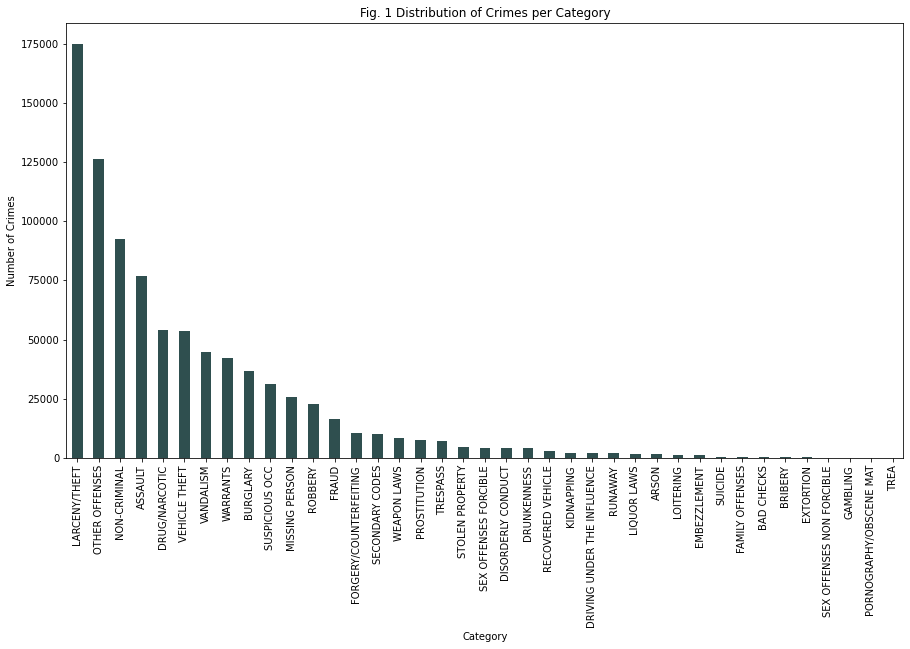

In [13]:
plot_bar('Category', 1)

На Fig. 1 се вижда, че разпределението на категориите (таргет променливата) е доста небалансирано - първите няколко са най-често срещаните, в сравнение с които последните изглежда са незначителни. Това ще трябва да се вземе предвид при избора на алгоритми и метрики.

In [14]:
data['Category'].describe()

count            878049
unique               39
top       LARCENY/THEFT
freq             174900
Name: Category, dtype: object

Има 39 различни категории престъпления, като най-често срещаната е Larceny/Theft.

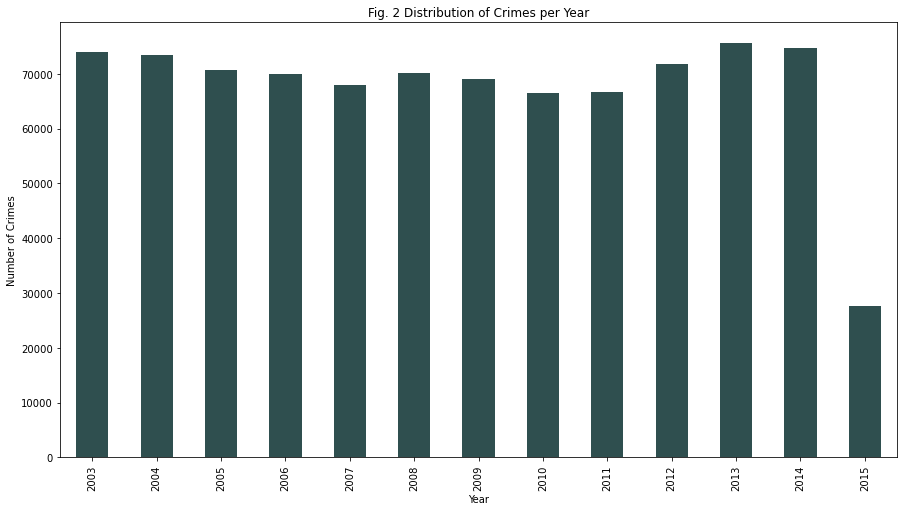

In [15]:
plot_bar('Year', fig_num=2, isChronological=True)

На Fig. 2 се вижда, че разпределението на престъпленията по години (между 2003 и 2015) е сравнително равномерно, но все пак се наблюдава спад на престъпленията между 2003 и 2008 и между 2008 и 2011, след което има покачване. Вижда се, че през 2015 разпределението на престъпленията е на половина, но и в dataset-а рекордите за престъпления за тази година са само до средата Й. 

In [16]:
data.groupby('Year')['Category'].describe()

,count,unique,top,freq
Year,,,,
2003,73902,37,LARCENY/THEFT,12990
2004,73422,37,LARCENY/THEFT,12111
2005,70779,37,LARCENY/THEFT,12402
2006,69909,38,LARCENY/THEFT,13798
2007,68015,38,LARCENY/THEFT,12760
2008,70174,38,LARCENY/THEFT,12800
2009,69000,37,LARCENY/THEFT,12538
2010,66542,39,LARCENY/THEFT,12214
2011,66619,38,LARCENY/THEFT,13084


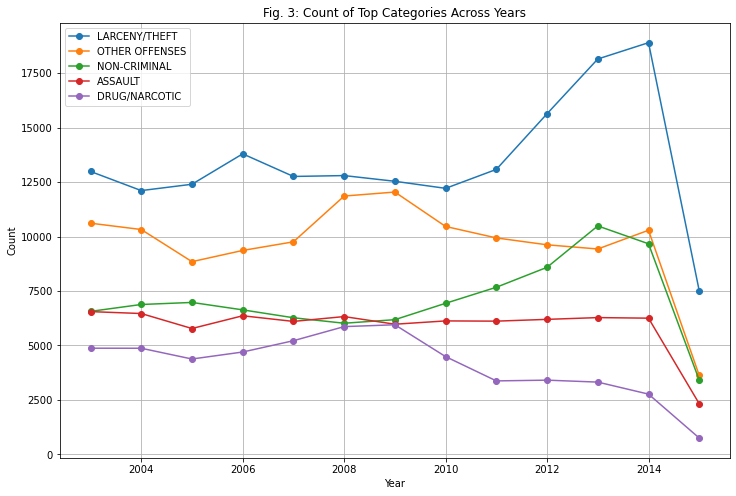

In [17]:
plot_line('Year', fig_num=3)

Na Fig. 3 наблюдаваме, че Larceny/Theft е водеща категория през всички години. В останалите топ 5 най-често срещани категории се случват леки размествания през годините, но като цяло най-често срещаните категории през всички години са си и най-често срещаните за всяка година. През някои от годините не са се случвали престъпления от някоя от категориите. Нека видим кои по-конкретно.

In [18]:
all_categories = set(data['Category'].unique())
unique_categories_per_year = data.groupby('Year')['Category'].unique()
missing_categories_per_year = {year: all_categories - set(categories) for year, categories in unique_categories_per_year.items()}
missing_categories_per_year

{2003: {'RECOVERED VEHICLE', 'TREA'},
 2004: {'RECOVERED VEHICLE', 'TREA'},
 2005: {'RECOVERED VEHICLE', 'TREA'},
 2006: {'TREA'},
 2007: {'TREA'},
 2008: {'TREA'},
 2009: {'PORNOGRAPHY/OBSCENE MAT', 'TREA'},
 2010: set(),
 2011: {'TREA'},
 2012: set(),
 2013: set(),
 2014: {'PORNOGRAPHY/OBSCENE MAT', 'RECOVERED VEHICLE'},
 2015: {'PORNOGRAPHY/OBSCENE MAT', 'RECOVERED VEHICLE'}}

Липсващите категории през някои от годините са и едни от най-рядко срещаните - TREA, RECOVERED VEHICLE, PORNOGRAPHY/OBSCENE MAT.

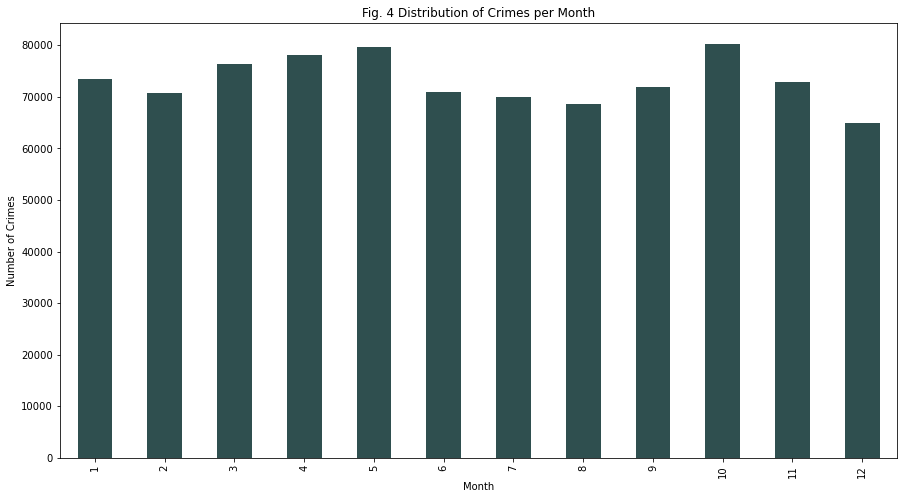

In [19]:
plot_bar('Month', fig_num=4, isChronological=True)

На графиката за разпределение на престъпленията по месеци се наблюдава, че през пролетните (3, 4, 5) и есенните месеци (9, 10, 11) се случват най-много престъпления. Най-малко са престъпленията през декември месец. Това е малко неинтуитивно, защото се очаква летните месеци, когато хората отиват на почивка и има туристи, или през зимните по празниците да се извършват повече престъпления. Може да се вземе предвид при обработката на данни и да се добави season характеристика и също така, за да се види дали категорията се влияе от това дали е празничен ден, може да се добави характеристика isHoliday.

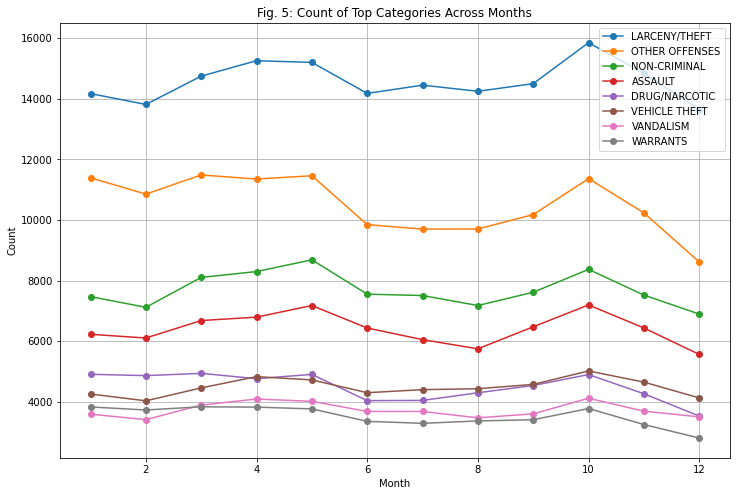

In [20]:
plot_line('Month', fig_num=5, categories_count=8)

На Fig. 5 за разпределението на престъпленията от топ 8 най-срещани категории по месеци се забелязва същата зависимост - и в 8те категории има известен спад на престъпленията през лятото и зимата, но при някои не е толкова голям като Vandalism и Warrants. При някои категории като Larceny/Theft и Non-Criminal в пролетните месеци се наблюдава завишаване, докато при други като Warrents и Drug/Narcotic не се забелязва.

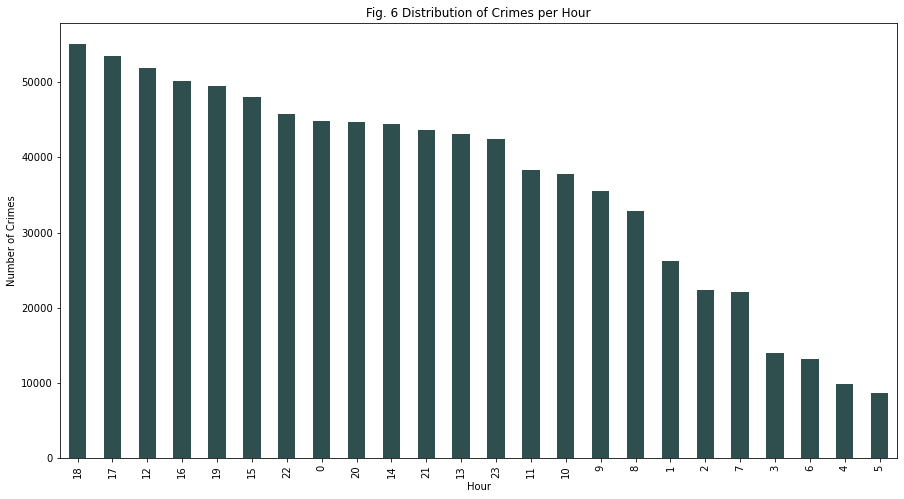

In [21]:
plot_bar('Hour', fig_num=6)

На графиката за разпределението на престъпленията по часове се наблюдава, че общо престъпленията се извършват най-често късно следобед и вечер до 12:00 am. Нека да видим дали същото се отнася и за отделните категории.

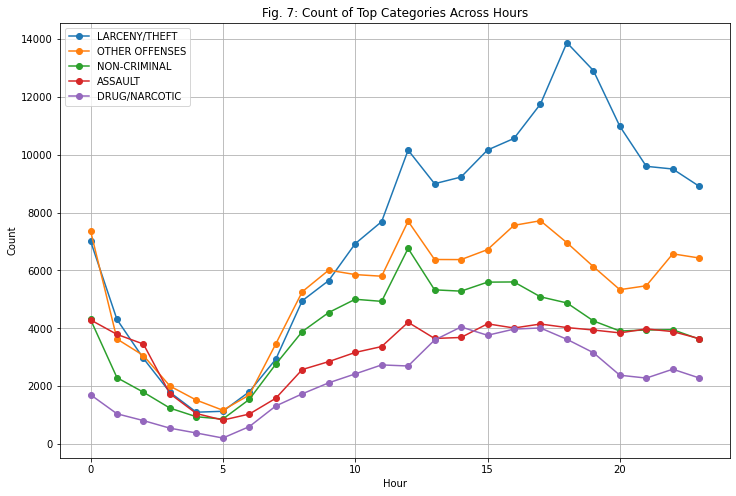

In [22]:
plot_line('Hour', fig_num=7)

На графиката, показваща разпределнията на престъпленията от топ 5 най-чести категории по часове, се забелязва същата зависимост - извършените престъпления дообяд и най-вече през нощта и рано сутрин между 1:00 и 6:00 са сравнително по-малко.  
Има обаче известни разлики в часовите диапазони и пиковете: 
- при DRUG/NARCOTIC пиковите часове са от 13:00 до 19:00
- при АSSAULT от 12:00 до към 2:00 са сравнително равномерно разпределени, но една идея по-пикови са 12:00 и 0:00
- при NON-CRIMINAL между 10:00 и 17:00 се наблюдават по-често, но с доста остър пик в 12:00
- при OTHER OFFENECES между 12:00 и 19:00 и между 22:00 и 0:00
- при LARCENY/THEFT между 12:00 и 23:00, като към 18:00-19:00 са доста повече  
   
Може да се експериментира с feature engineering, като се добави характеристика за часовия диапазон (morning, afternoon, evening, night), и да се види какъв е перформънса на модела спрямо различните feature-и и дали влияе по-скоро конкратен час или не.

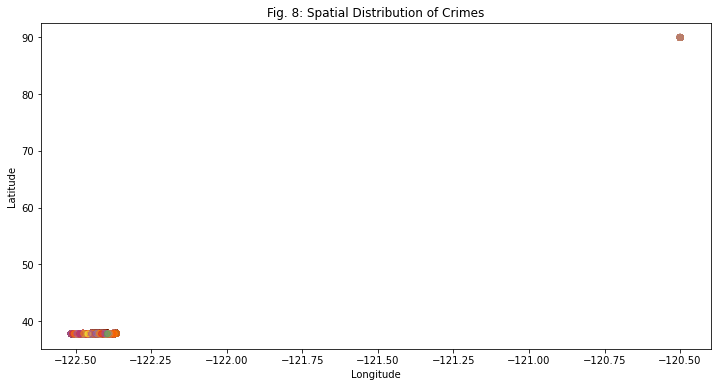

In [23]:
plt.figure(figsize=(12, 6))
plt.scatter(data['X'], data['Y'], c=data['Category'].astype('category').cat.codes, cmap='Set1', alpha=0.5)
plt.title('Fig. 8: Spatial Distribution of Crimes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

На Fig. 8 се вижда, че повечето престъпления са в един участък, освен няколко outlier-а, които ще трябва да се вземат предвид при обработката на данни. По данни от Google San Francisco се намира на ширина 37.773972, дължина -122.431297. Следователно outlier-ите с ширина по-голяма от 37.773972 и дължина по-малка от -122.431297 трябва да се премахнат.

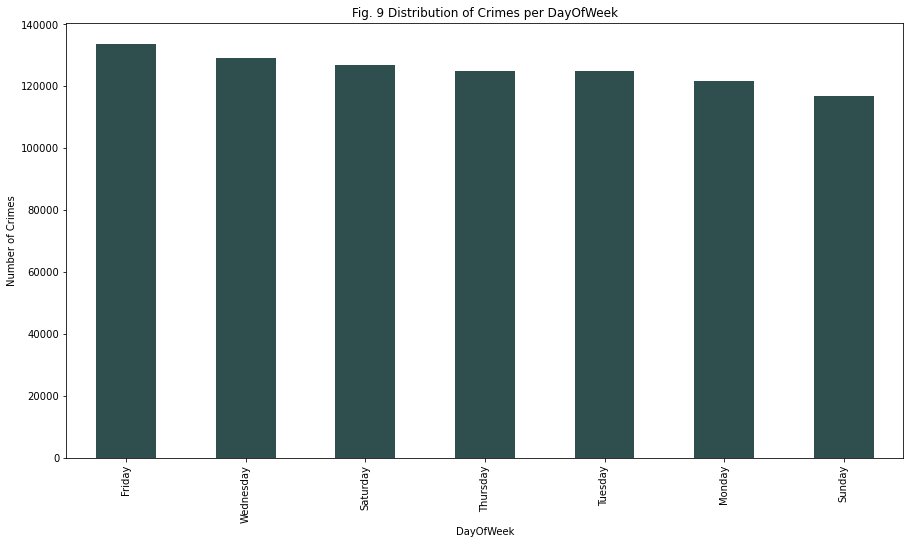

In [24]:
plot_bar('DayOfWeek', fig_num=9)

На фигурата за разпределението на престъпленията по дни в седмицата се наблюдава, че са срванително равномерно разпределени, но в петък са най-много.

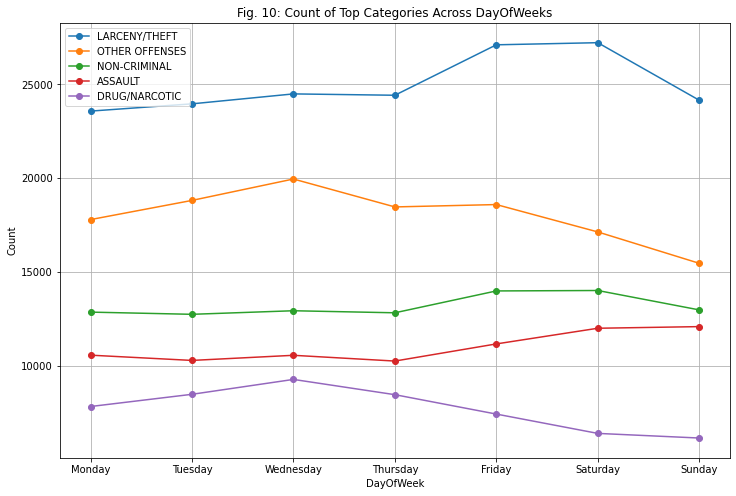

In [25]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['DayOfWeek'] = pd.Categorical(data['DayOfWeek'], categories=day_order, ordered=True)
plot_line('DayOfWeek', fig_num=10)

На фигурата за разпраделението на престъпленията за топ 5 най-чести категории по дни в седмицата, се забелязва, че престъпленията в някои от категориите намаляват по време на уикенда (OTHER OFFENCES, DRUG/NARCOTIC), докато други (ASSAULT) се увеличават. С това също може да се експериментира по време на feature engineering и да се види как влияе на перформънса на модела.

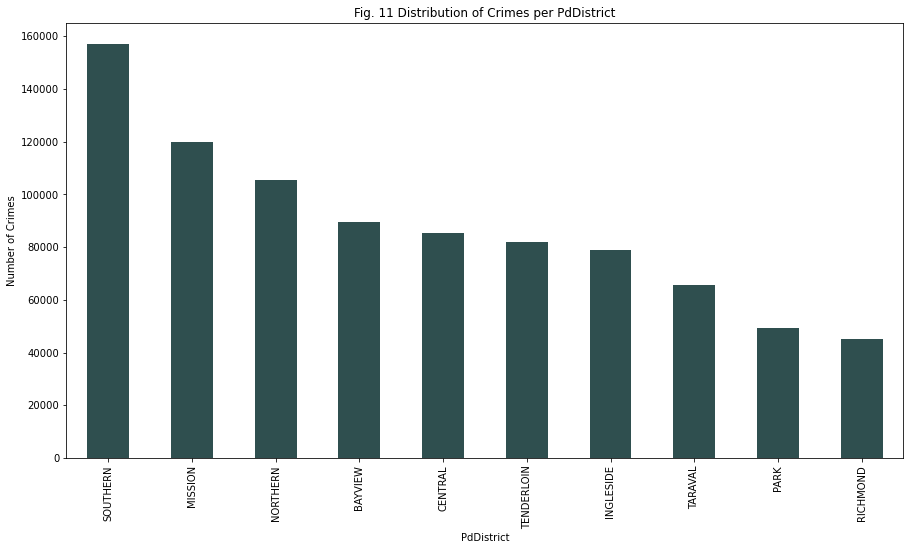

In [26]:
plot_bar('PdDistrict', fig_num=11)

На Fig. 6 се забелязва как престъпленията нямаляват спрямо района на полицейските участъци.

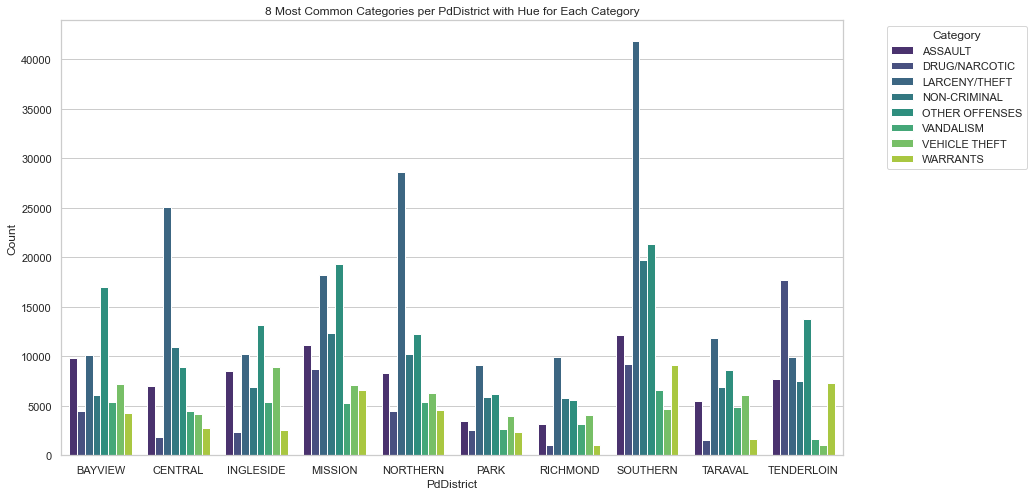

In [27]:
barplot_with_hue('PdDistrict')

От горната графика се забелязва, че различните категории престъпления имат различно density за различните участъци. Например въпреки, че в Richmond се случват най-малко престъпления, най-малко Vehicle Theft престъпления се случват в Tenderloin. Това показва, че може би този feature, ще е от значение при предсказването на категорията.

In [28]:
data['Address'].value_counts()

800 Block of BRYANT ST         26533
800 Block of MARKET ST          6581
2000 Block of MISSION ST        5097
1000 Block of POTRERO AV        4063
900 Block of MARKET ST          3251
                               ...  
BOYLSTON ST / SWEENY ST            1
PARK PRESIDIO BL / GEARY BL        1
33RD AV / MORAGA ST                1
22ND ST / VICKSBURG ST             1
GRAYSTONE TR / TWINPEAKS BL        1
Name: Address, Length: 23228, dtype: int64

От тук виждаме, че има 23 228 уникални адреса и че най-вероятно повечето адреси са или block, или intersection (/). Нека видим дали може всички да ги разделим на тези 2 категории.

In [29]:
block_records = data[data['Address'].str.contains('block', case=False, na=False)]
block_records_count = len(block_records)

intersection_records = data[data['Address'].str.contains('/', case=False, na=False)]
intersection_records_count = len(intersection_records)

block_records_count + intersection_records_count == data.shape[0]

True

Всички адреси са или block, или intersection, така че при обработката на данни може да заменим Address характеристиката с това дали престъплението се е случило на block или intersection и да видим как се справя модела, защото уникалните стойности за Address са доста и при encodе-ването им размерността na feature вектора ще стане доста голяма.

In [54]:
del block_records
del intersection_records

#### Предварителна обработка на данните

В EDA секцията установихме, че няма липсващи стойности в нито една от характеристиките, но има outlier-и, чиято информация е грешна. Тези outlier-и трябва да бъдат премахнати от сета с данни, използвайки Z-score.

In [4]:
z_scores_x = np.abs((data['X'] - data['X'].mean()) / data['X'].std())
z_scores_y = np.abs((data['Y'] - data['Y'].mean()) / data['Y'].std())

# Set a threshold for Z-score (e.g., 3, which is a common choice)
threshold = 3

# Remove rows where Z-score is below the threshold for both 'X' and 'Y'
data = data[(z_scores_x < threshold) & (z_scores_y < threshold)]
data.describe()

,X,Y,Year,Month,Day,Hour,Minute
count,877982.000000,877982.000000,877982.000000,877982.000000,877982.000000,877982.000000,877982.000000
mean,-122.422763,37.767035,2008.712378,6.436416,15.570501,13.412737,20.155163
std,0.025285,0.024165,3.631126,3.428998,8.782976,6.549521,18.595053
min,-122.513642,37.707879,2003.000000,1.000000,1.000000,0.000000,0.000000
25%,-122.432952,37.752427,2006.000000,3.000000,8.000000,9.000000,0.000000
50%,-122.416420,37.775421,2009.000000,6.000000,16.000000,14.000000,19.000000
75%,-122.406959,37.784368,2012.000000,9.000000,23.000000,19.000000,33.000000
max,-122.364937,37.819975,2015.000000,12.000000,31.000000,23.000000,59.000000


In [5]:
del z_scores_x
del z_scores_y

Премахваме излишните за проблема характеристики и добавяме обсъдените в EDA.

In [6]:
#Remove Resolution and Descript characterics from the data frama
data = data.drop(['Resolution', 'Descript'], axis=1)

По време на EDA превърнахме Dates стринга в datatime и извлякохме годината, месеца и часа в отделни характеристики. Отбелязахме, че може да има корелация между типа престъпление и сезона (пролет, лято, есен, зима), както и времевия диапазон на престъплението (ранна сутрин, късна сутрин, ранен следобед, късен следобед, вечер, нощ) и дали е по време на работни часове. Нека ги добавим като характеристики.

In [7]:
def extract_season(month):
    if (month >= 12) or (month <= 2):
        return 'winter'
    elif (month >= 3) and (month <= 5):
        return 'spring'
    elif (month >= 6) and (month <= 8):
        return 'summer'
    else:
        return 'autumn' 

def extract_hour_range(hour):
    if (hour >= 6) and (hour < 10):
        return 'early-morning'
    elif (hour >= 10) and (hour < 12):
        return 'late-morning'
    elif (hour >= 12) and (hour < 15):
        return 'early-afternoon'
    elif (hour >= 15) and (hour < 18):
        return 'late-afternoon'
    elif (hour >= 18) or (hour < 1):
        return 'evening'
    else:
        return 'night'

def extract_is_during_business_hours(day_of_week, hour):
    return 1 if (day_of_week != 'Saturday') and (day_of_week != 'Sunday') and (hour >= 9) and (hour < 17) else 0

In [8]:
# Add a field season (winter, spring, summer, autumn) based on the month of the crime
data['Season'] = data['Month'].apply(func=extract_season)

# Add a field HourRange (early-morning, late-morning, early-afternoon, late-afternoon, evening, night) based on the hour of the crime
data['HourRange'] = data['Hour'].apply(func=extract_hour_range)

# Add a field IsDuringBusinessHours that says if the crime occured between 9am and 5pm Monday to Friday
data['IsDuringBusinessHours'] = data.apply(lambda row: extract_is_during_business_hours(row['DayOfWeek'], row['Hour']), axis=1)

Също така беше споменато, че може да има корелация между категорията на престъплението и това дали е извършено през уикенда или през празничен ден.

In [9]:
# Add a field IsWeekend (0=False, 1=True) based on the day of the week the crime happened
data['IsWeekend'] = data['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)

# Get all US public holidays
us_holidays = holidays.UnitedStates(years=data['Dates'].dt.year.unique())

# Add a field IsHoliday (0=False, 1=True) based on the date of the crime happened
data['IsHoliday'] = data['Dates'].dt.date.astype('datetime64').isin(us_holidays).astype(int)

За да не загубим връзката между отделните компоненти и да запазим датата като точка във времето ще трансформираме datatime обекта в epoch time и ще премахнем колоната Dates, тъй като не можем да я използваме при тренирането на модела.

In [10]:
data['EpochTime'] = data['Dates'].apply(lambda x: x.timestamp())

In [11]:
data.drop('Dates', axis=1, inplace=True)

В EDA секцията беше установено, че адресите на престъплението са или на block, или на intersection. Добавяме ново поле, установяващо дали престъплението се е случило на block и премахваме полето за Address, тъй като е текстово и е по-сложно да го използваме при установяване на някаква зависимост.

In [12]:
def extract_address_type(address):
    return 1 if 'block' in address.lower() else 0

In [13]:
# Add a field isOnBlock based on the Address (wether the crime happened on a block or intersection)
data['IsOnBlock'] = data['Address'].apply(func=extract_address_type)

In [14]:
data.drop('Address', axis=1, inplace=True)

След добавянето на всички нови полета, данните изглеждат така:

In [15]:
data.head(3)

,Category,DayOfWeek,PdDistrict,X,Y,Year,Month,Day,Hour,Minute,Season,HourRange,IsDuringBusinessHours,IsWeekend,IsHoliday,EpochTime,IsOnBlock
0,WARRANTS,Wednesday,NORTHERN,-122.425892,37.774599,2015,5,13,23,53,spring,evening,0,0,0,1.431561e+09,0
1,OTHER OFFENSES,Wednesday,NORTHERN,-122.425892,37.774599,2015,5,13,23,53,spring,evening,0,0,0,1.431561e+09,0
2,OTHER OFFENSES,Wednesday,NORTHERN,-122.424363,37.800414,2015,5,13,23,33,spring,evening,0,0,0,1.431560e+09,0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877982 entries, 0 to 878048
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Category               877982 non-null  object 
 1   DayOfWeek              877982 non-null  object 
 2   PdDistrict             877982 non-null  object 
 3   X                      877982 non-null  float64
 4   Y                      877982 non-null  float64
 5   Year                   877982 non-null  int64  
 6   Month                  877982 non-null  int64  
 7   Day                    877982 non-null  int64  
 8   Hour                   877982 non-null  int64  
 9   Minute                 877982 non-null  int64  
 10  Season                 877982 non-null  object 
 11  HourRange              877982 non-null  object 
 12  IsDuringBusinessHours  877982 non-null  int64  
 13  IsWeekend              877982 non-null  int32  
 14  IsHoliday              877982 non-nu

Характеристиките DayOfWeek, PdDistrict, Address, HourRange, Season са категорийни. За да ги използваме в алгоритмите трябва да ги encode-нем. Но при използването на различните алгоритми, ще го направим по различен начин, тъй като нямат ординална връзка би трябвало да използваме one-hot-encoding, но при Random Forest алгоритъма например ординалността няма значение и може да си ги енкоднем с числа.  
И тъй като също така ще експериментираме с използването на различни характеристики, нека запазим досегашните данни.

In [17]:
original = data.copy()
original.head(3)

,Category,DayOfWeek,PdDistrict,X,Y,Year,Month,Day,Hour,Minute,Season,HourRange,IsDuringBusinessHours,IsWeekend,IsHoliday,EpochTime,IsOnBlock
0,WARRANTS,Wednesday,NORTHERN,-122.425892,37.774599,2015,5,13,23,53,spring,evening,0,0,0,1.431561e+09,0
1,OTHER OFFENSES,Wednesday,NORTHERN,-122.425892,37.774599,2015,5,13,23,53,spring,evening,0,0,0,1.431561e+09,0
2,OTHER OFFENSES,Wednesday,NORTHERN,-122.424363,37.800414,2015,5,13,23,33,spring,evening,0,0,0,1.431560e+09,0


#### Моделиране на данните

##### Random Forest

Random Forest алгоритъма се справя добре и без one-hot-encodе-ване на неординални категорийни данни, каквито са PdDistrict, Season, HourRange, но все пак трябва да се encode-нат, защото sckit-learn алгоритъма не може да работи с категорийни данни. Ще използваме LabelEncoder, за да зададем различна числова стойност на категориите на дадена характеристика.

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [17]:
data['DayOfWeek'] = LabelEncoder().fit_transform(data['DayOfWeek'])
data['PdDistrict'] = LabelEncoder().fit_transform(data['PdDistrict'])
data['Season'] = LabelEncoder().fit_transform(data['Season'])
data['HourRange'] = LabelEncoder().fit_transform(data['HourRange'])

Ще дефинираме три функции:
- за изобразяване на feature importance
- за изчисляване на log loss-a
- за показване на classification report
- за разделяне на множеството данни на train-val-test множества
- за намиране на хипер параметри чрез RandomizedSearch (избираме го пред GridSearch, тъй като имаме доста голям dataset от ~ 800 000 samples и използването му ще е доста скъпо от към ресурси)

In [18]:
def random_forest_features(model, X):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 10))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns, rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [19]:
from sklearn.metrics import log_loss


def log_loss_evaluation(model, X, y):
    y_pred_proba = model.predict_proba(X)
    return log_loss(y, y_pred_proba)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix


def classification_report_results(model, X, y):
    y_pred = pd.DataFrame(model.predict(X))
    return classification_report(y_true=y, y_pred=y_pred, zero_division=0)
    # return confusion_matrix(y, y_pred)

In [21]:
from sklearn.model_selection import train_test_split


def train_val_test_split(data):
    X = data.drop('Category', axis=1)
    y = data['Category']

    # Split sets into training and temporary sets (60% train, 40% test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)

    # Further split the temporary set into validation and test sets (50% validation, 50% test)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, stratify=y_temp)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [22]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


def randomized_search_results(param_grid, n_iter, model, X, y):
    # Create GridSearchCV object
    # grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=3, verbose=1)
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='neg_log_loss', n_iter=n_iter, cv=3, random_state=42)

    # Fit the grid search to the data
    random_search.fit(X, y)

    # Display the results
    return pd.DataFrame(random_search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(n_iter)


Ще изпробваме модела без задаване на хиперпараметри и ще го оценим върху validation set-а, използвайки LogLoss метриката. 

In [52]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data)

In [53]:
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [55]:
print("train score:", log_loss_evaluation(model, X_train, y_train))
print("validation score: ", log_loss_evaluation(model, X_val, y_val))

train score: 0.44207197954662536
validation score:  4.649515884356734


Използването на RandomForest без задаване на параметри overfitt-ва изключително много. Ще направим един GridSearch, за да видим дали ще намерим по-добри параметри за n_estimators или max_depth.

In [57]:
param_grid = {
    'n_estimators': [10, 30, 50, 70, 100],
    'max_depth': [2, 4, 6, 8, 10, 12, 15, 20],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Display the results
results = randomized_search_results(param_grid, 10, model, X_train, y_train)
results

,rank_test_score,mean_test_score,params
4,1,-2.356834,"{'n_estimators': 70, 'min_samples_split': 2, '..."
9,2,-2.407715,"{'n_estimators': 10, 'min_samples_split': 2, '..."
8,3,-2.426268,"{'n_estimators': 50, 'min_samples_split': 50, ..."
0,4,-2.432612,"{'n_estimators': 10, 'min_samples_split': 10, ..."
1,5,-2.434250,"{'n_estimators': 10, 'min_samples_split': 50, ..."
3,6,-2.469174,"{'n_estimators': 70, 'min_samples_split': 20, ..."
7,7,-2.519984,"{'n_estimators': 10, 'min_samples_split': 100,..."
5,8,-2.581823,"{'n_estimators': 10, 'min_samples_split': 5, '..."
2,9,-2.583089,"{'n_estimators': 100, 'min_samples_split': 50,..."
6,10,-2.584418,"{'n_estimators': 70, 'min_samples_split': 2, '..."


Да погледнем по-подробно параметрите на първите 3 най-добри резултата (с най-малък log loss).

In [62]:
for i in range(3):
    print(results.iloc[i]['params'])

{'n_estimators': 70, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 12}
{'n_estimators': 10, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 10}
{'n_estimators': 50, 'min_samples_split': 50, 'max_features': 'auto', 'max_depth': 8}


In [63]:
del results

Нека тренираме модел с параметрите на най-добрия резултат и да го оценим.

In [64]:
model = RandomForestClassifier(random_state=0, max_depth=12, n_estimators=70, min_samples_split=2)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=70, random_state=0)

In [65]:
print("train score:", log_loss_evaluation(model, X_train, y_train))
print("validation score: ", log_loss_evaluation(model, X_val, y_val))

train score: 2.2243808060354633
validation score:  2.352974076408288


Разликата между log loss-a на тренировъчното и валидационното множество е ~0.13, което не е знак за overfitting при положение, но нека видим как модела се справя и параметрите от втория най-добър резултат.

In [71]:
model = RandomForestClassifier(random_state=0, max_depth=10, n_estimators=10, min_samples_split=2, max_features='sqrt')
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=10,
                       random_state=0)

In [69]:
print("train score:", log_loss_evaluation(model, X_train, y_train))
print("validation score: ", log_loss_evaluation(model, X_val, y_val))

train score: 2.348193866535017
validation score:  2.3974547802613646


Тук разликата в log loss-a е сравнително по-малка - ~0.05. Тук съвсем няма overfitting, но модела се справя малко по-зле.  
Нека погледнем classification report-а за модела.

In [104]:
print(classification_report_results(model, X_val, y_val))

                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.17      0.13      0.15     15374
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.19      0.01      0.01      7351
         DISORDERLY CONDUCT       0.26      0.01      0.02       863
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.35      0.31      0.33     10794
                DRUNKENNESS       0.00      0.00      0.00       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.00      0.00      0.00      2122
                      FRAUD      

Разглеждайки classification report-а, се наблюдава, че за доста от класовете, най-вече тези от minority-то, precision и recall метриките са 0, което означава, че модела не се е справил в предсказването на категориите с по-малък сет от данни.

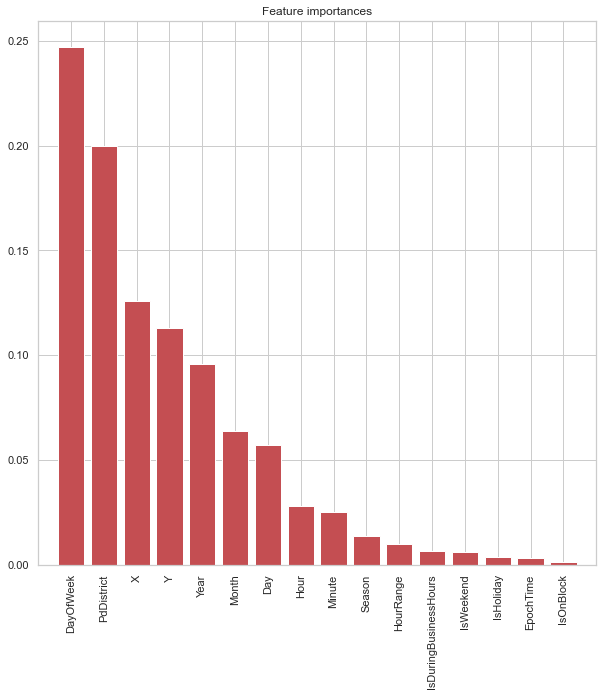

In [72]:
random_forest_features(model, X_val)

Нека изпробваме алгоритъма само без feature-ите, които добавихме като сезон, часови диапазон и т.н, тъй като те изглежда нямат голямо значение в модела, използващ всички feature-и.  

In [24]:
data_selection = data.drop(columns=['Season', 'HourRange', 'IsDuringBusinessHours', 'IsWeekend', 'IsHoliday'])
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data_selection)

In [25]:
del data_selection, X_val, X_test, y_val, y_test

In [26]:
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [29]:
data_selection = data.drop(columns=['Season', 'HourRange', 'IsDuringBusinessHours', 'IsWeekend', 'IsHoliday'])
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data_selection)
del data_selection, X_test, y_test

print("train score: ", log_loss_evaluation(model, X_train, y_train))
print("validation score: ", log_loss_evaluation(model, X_val, y_val))

train score:  0.440942007304384
validation score:  4.701870795602136


Без хипер параметри този модел също overfit-ва изключително много. Затова и тук правим RandomizedSearch.

In [31]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [10, 30, 50, 70, 100],
    'max_depth': [2, 4, 6, 8, 10, 12, 15, 20],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2']
}

model = RandomForestClassifier(random_state=0)

# Display the results
results = randomized_search_results(param_grid, 10, model, X_train, y_train)
results

,rank_test_score,mean_test_score,params
4,1,-2.351461,"{'n_estimators': 70, 'min_samples_split': 2, '..."
9,2,-2.400385,"{'n_estimators': 10, 'min_samples_split': 2, '..."
8,3,-2.421141,"{'n_estimators': 50, 'min_samples_split': 50, ..."
0,4,-2.425836,"{'n_estimators': 10, 'min_samples_split': 10, ..."
1,5,-2.429335,"{'n_estimators': 10, 'min_samples_split': 50, ..."
3,6,-2.466086,"{'n_estimators': 70, 'min_samples_split': 20, ..."
7,7,-2.523768,"{'n_estimators': 10, 'min_samples_split': 100,..."
6,8,-2.581215,"{'n_estimators': 70, 'min_samples_split': 2, '..."
2,9,-2.581606,"{'n_estimators': 100, 'min_samples_split': 50,..."
5,10,-2.586903,"{'n_estimators': 10, 'min_samples_split': 5, '..."


In [32]:
for i in range(3):
    print(results.iloc[i]['params'])

{'n_estimators': 70, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 12}
{'n_estimators': 10, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 10}
{'n_estimators': 50, 'min_samples_split': 50, 'max_features': 'auto', 'max_depth': 8}


In [33]:
del results

In [34]:
model = RandomForestClassifier(random_state=0, max_depth=12, n_estimators=70, min_samples_split=2)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=70, random_state=0)

In [35]:
print("train score: ", log_loss_evaluation(model, X_train, y_train))
print("validation score: ", log_loss_evaluation(model, X_val, y_val))

train score:  2.2163012923197973
validation score:  2.345499733367989


In [36]:
print(classification_report_results(model, X_val, y_val))

                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.18      0.18      0.18     15374
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.26      0.00      0.01      7351
         DISORDERLY CONDUCT       0.10      0.01      0.01       863
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.34      0.36      0.35     10794
                DRUNKENNESS       0.00      0.00      0.00       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.11      0.00      0.00      2122
                      FRAUD      

Този модел няма голяма разлика с горния - precision и recall-a за minority категориите е нулев, което показва, че не генерализира добре.  
Нека изпробваме модела и само с feature-ите, които добавихме, анализирайки датата.

In [25]:
data_selection = data.drop(columns=['Hour', 'Minute', 'Month', 'EpochTime'])
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data_selection)

In [26]:
del data_selection, X_val, X_test, y_val, y_test

In [27]:
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [28]:
data_selection = data.drop(columns=['Hour', 'Minute', 'Month', 'EpochTime'])
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data_selection)
del data_selection, X_test, y_test

print("train score: ", log_loss_evaluation(model, X_train, y_train))
print("validation score: ", log_loss_evaluation(model, X_val, y_val))

train score:  0.46171669495718615
validation score:  5.5404305663884585


И този модел overfit-ва без настроени хиперпараметри. И за него правим RandomizedSearch.

In [30]:
param_grid = {
    'n_estimators': [10, 30, 50, 70, 100, 200],
    'max_depth': [2, 4, 6, 8, 10, 12, 15, 20],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2']
}

# del X_val, y_val
model = RandomForestClassifier(random_state=0)

# Display the results
results = randomized_search_results(param_grid, 10, model, X_train, y_train)
results

,rank_test_score,mean_test_score,params
6,1,-2.424118,"{'n_estimators': 200, 'min_samples_split': 10,..."
2,2,-2.425210,"{'n_estimators': 200, 'min_samples_split': 20,..."
9,3,-2.433129,"{'n_estimators': 30, 'min_samples_split': 10, ..."
8,4,-2.452946,"{'n_estimators': 200, 'min_samples_split': 10,..."
7,5,-2.520582,"{'n_estimators': 100, 'min_samples_split': 5, ..."
5,6,-2.520877,"{'n_estimators': 200, 'min_samples_split': 5, ..."
3,7,-2.520906,"{'n_estimators': 70, 'min_samples_split': 20, ..."
1,8,-2.559857,"{'n_estimators': 10, 'min_samples_split': 2, '..."
0,9,-2.563660,"{'n_estimators': 10, 'min_samples_split': 20, ..."
4,10,-2.609841,"{'n_estimators': 200, 'min_samples_split': 20,..."


In [31]:
for i in range(10):
    print(results.iloc[i]['params'])

{'n_estimators': 200, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 12}
{'n_estimators': 200, 'min_samples_split': 20, 'max_features': 'log2', 'max_depth': 12}
{'n_estimators': 30, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 12}
{'n_estimators': 200, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 10}
{'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 6}
{'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 6}
{'n_estimators': 70, 'min_samples_split': 20, 'max_features': 'log2', 'max_depth': 6}
{'n_estimators': 10, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 15}
{'n_estimators': 10, 'min_samples_split': 20, 'max_features': 'log2', 'max_depth': 4}
{'n_estimators': 200, 'min_samples_split': 20, 'max_features': 'auto', 'max_depth': 2}


Нека пробваме модела с {'n_estimators': 30, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': 12}, тъй като разликата в log loss-a с най-добрия резултат не е голяма (~0,01), a използва доста по-малко дървета.

In [32]:
del results

In [33]:
model = RandomForestClassifier(random_state=0, max_depth=12, n_estimators=30, min_samples_split=10, max_features='log2')
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, max_features='log2', min_samples_split=10,
                       n_estimators=30, random_state=0)

In [34]:
data_selection = data.drop(columns=['Hour', 'Minute', 'Month', 'EpochTime'])
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data_selection)
del data_selection, X_test, y_test

print("train score: ", log_loss_evaluation(model, X_train, y_train))
print("validation score: ", log_loss_evaluation(model, X_val, y_val))

train score:  2.3179143790328136
validation score:  2.4266910031964004


In [35]:
print(classification_report_results(model, X_val, y_val))

                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.18      0.15      0.16     15374
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.24      0.00      0.01      7351
         DISORDERLY CONDUCT       0.13      0.00      0.01       863
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.31      0.36      0.34     10794
                DRUNKENNESS       0.00      0.00      0.00       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.00      0.00      0.00      2122
                      FRAUD      

И с този сет от характеристики не се наблюдава някакво подобрение в алгоритъма - и той не генерализира добре (повечете minority класове не се отчетени).  
Нека да видим и важността на feature-ите.

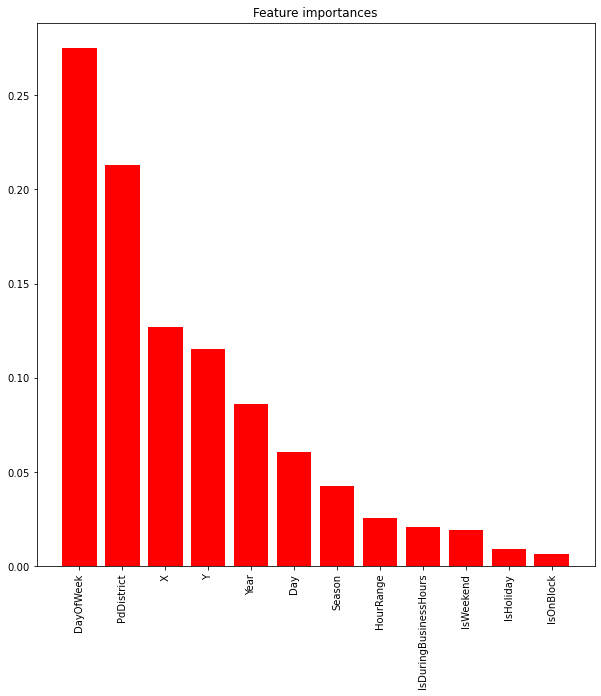

In [36]:
random_forest_features(model, X_val)

In [39]:
param_grid = {
    'n_estimators': [10, 30, 50, 70, 100],
    'max_depth': [2, 4, 6, 8, 10, 12, 15, 20],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
}

# del X_val, y_val
model = RandomForestClassifier(random_state=0)

# Display the results
results = randomized_search_results(param_grid, 20, model, X_train, y_train)
results

,rank_test_score,mean_test_score,params
11,1,-2.426430,"{'n_estimators': 30, 'min_samples_split': 100,..."
18,2,-2.427523,"{'n_estimators': 50, 'min_samples_split': 2, '..."
13,3,-2.428121,"{'n_estimators': 70, 'min_samples_split': 20, ..."
6,4,-2.429476,"{'n_estimators': 70, 'min_samples_split': 50, ..."
5,5,-2.430516,"{'n_estimators': 50, 'min_samples_split': 50, ..."
9,6,-2.453919,"{'n_estimators': 70, 'min_samples_split': 50, ..."
19,7,-2.465951,"{'n_estimators': 10, 'min_samples_split': 5, '..."
12,8,-2.485144,"{'n_estimators': 100, 'min_samples_split': 50,..."
3,9,-2.485541,"{'n_estimators': 100, 'min_samples_split': 20,..."
14,10,-2.485719,"{'n_estimators': 70, 'min_samples_split': 50, ..."


In [41]:
for i in range(20):
    print(results.iloc[i]['params'])

{'n_estimators': 30, 'min_samples_split': 100, 'max_depth': 15}
{'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 12}
{'n_estimators': 70, 'min_samples_split': 20, 'max_depth': 12}
{'n_estimators': 70, 'min_samples_split': 50, 'max_depth': 20}
{'n_estimators': 50, 'min_samples_split': 50, 'max_depth': 12}
{'n_estimators': 70, 'min_samples_split': 50, 'max_depth': 10}
{'n_estimators': 10, 'min_samples_split': 5, 'max_depth': 10}
{'n_estimators': 100, 'min_samples_split': 50, 'max_depth': 8}
{'n_estimators': 100, 'min_samples_split': 20, 'max_depth': 8}
{'n_estimators': 70, 'min_samples_split': 50, 'max_depth': 8}
{'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 8}
{'n_estimators': 70, 'min_samples_split': 2, 'max_depth': 8}
{'n_estimators': 30, 'min_samples_split': 100, 'max_depth': 6}
{'n_estimators': 10, 'min_samples_split': 5, 'max_depth': 15}
{'n_estimators': 10, 'min_samples_split': 20, 'max_depth': 4}
{'n_estimators': 30, 'min_samples_split': 5, 'max_depth': 2}


In [ ]:
del results

Нека сменим малко параметрите за grid-a и да видим дали ще получим по-добри резултати.

In [23]:
data_selection = data.drop(columns=['Hour', 'Minute', 'Month', 'Day', 'DayOfWeek', 'EpochTime'])
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data_selection)
del data_selection, X_test, y_test, X_val, y_val

param_grid = {
    'n_estimators': [30, 50, 70],
    'max_depth': [2, 4, 6, 8, 10, 12, 15, 20],
    'min_samples_split': [2, 5, 10, 20, 50, 100],
}

model = RandomForestClassifier(random_state=0)

# Display the results
results = randomized_search_results(param_grid, 20, model, X_train, y_train)
results

,rank_test_score,mean_test_score,params
18,1,-2.401734,"{'n_estimators': 70, 'min_samples_split': 100,..."
12,2,-2.416703,"{'n_estimators': 50, 'min_samples_split': 5, '..."
14,3,-2.417473,"{'n_estimators': 50, 'min_samples_split': 20, ..."
3,4,-2.417715,"{'n_estimators': 50, 'min_samples_split': 10, ..."
0,5,-2.427432,"{'n_estimators': 30, 'min_samples_split': 20, ..."
19,6,-2.443360,"{'n_estimators': 50, 'min_samples_split': 2, '..."
2,7,-2.443497,"{'n_estimators': 50, 'min_samples_split': 20, ..."
11,8,-2.447686,"{'n_estimators': 30, 'min_samples_split': 10, ..."
4,9,-2.476046,"{'n_estimators': 70, 'min_samples_split': 2, '..."
7,10,-2.476528,"{'n_estimators': 70, 'min_samples_split': 20, ..."


In [24]:
for i in range(20):
    print(results.iloc[i]['params'])

{'n_estimators': 70, 'min_samples_split': 100, 'max_depth': 15}
{'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 12}
{'n_estimators': 50, 'min_samples_split': 20, 'max_depth': 12}
{'n_estimators': 50, 'min_samples_split': 10, 'max_depth': 12}
{'n_estimators': 30, 'min_samples_split': 20, 'max_depth': 15}
{'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 10}
{'n_estimators': 50, 'min_samples_split': 20, 'max_depth': 10}
{'n_estimators': 30, 'min_samples_split': 10, 'max_depth': 10}
{'n_estimators': 70, 'min_samples_split': 2, 'max_depth': 8}
{'n_estimators': 70, 'min_samples_split': 20, 'max_depth': 8}
{'n_estimators': 50, 'min_samples_split': 20, 'max_depth': 8}
{'n_estimators': 30, 'min_samples_split': 100, 'max_depth': 8}
{'n_estimators': 30, 'min_samples_split': 50, 'max_depth': 8}
{'n_estimators': 30, 'min_samples_split': 100, 'max_depth': 6}
{'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 4}
{'n_estimators': 30, 'min_samples_split': 20, 'max_depth': 4}
{

In [25]:
del results

Получават се малко по-добри резултати, затова ще тренираме модел с тези параметри {'n_estimators': 70, 'min_samples_split': 100, 'max_depth': 15}

In [26]:
model = RandomForestClassifier(random_state=0, max_depth=15, n_estimators=70, min_samples_split=100)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_split=100, n_estimators=70,
                       random_state=0)

In [28]:
data_selection = data.drop(columns=['Hour', 'Minute', 'Month', 'Day', 'DayOfWeek', 'EpochTime'])
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data_selection)
del data_selection, X_test, y_test

print("train score: ", log_loss_evaluation(model, X_train, y_train))
print("validation score: ", log_loss_evaluation(model, X_val, y_val))

train score:  2.2335429595227616
validation score:  2.3892913788994066


In [29]:
print(classification_report_results(model, X_val, y_val))

                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       303
                    ASSAULT       0.18      0.17      0.18     15374
                 BAD CHECKS       0.00      0.00      0.00        81
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.22      0.02      0.04      7351
         DISORDERLY CONDUCT       0.25      0.01      0.02       863
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       454
              DRUG/NARCOTIC       0.32      0.41      0.36     10794
                DRUNKENNESS       0.00      0.00      0.00       856
               EMBEZZLEMENT       0.00      0.00      0.00       233
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        98
     FORGERY/COUNTERFEITING       0.00      0.00      0.00      2122
                      FRAUD      

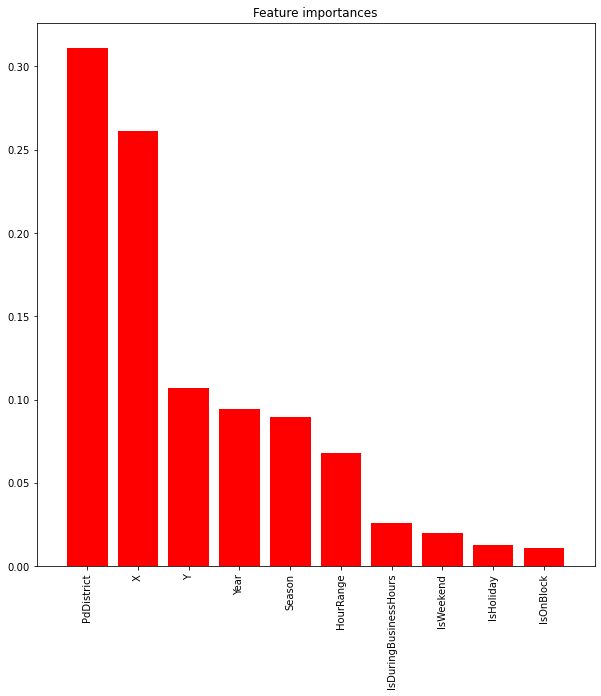

In [30]:
random_forest_features(model, X_val)

И с този модел не наблюдаваме подобрение в генерализирането. Като цяло от важността на feature-ите се вижда, че от най-голямо значение са по-скоро пространствените характеристики отколкото времевите.

На dataframe-a, показващ резултатите от прилагането на RandomForest върху различните set-ове от feature-и с различни параметри, където:
- Set1 = {DayOfWeek, PdDistrict, X, Y, Year, Month, Day, Hour, Minute, EpochTime, IsOnBlock, Season, HourRange, IsDuringBusinessHours, IsWeekend, IsHoliday}
- Set2 = {DayOfWeek, PdDistrict, X, Y, Year, Month, Day, Hour, Minute, EpochTime, IsOnBlock}
- Set3 = {DayOfWeek, PdDistrict, X, Y, Year, IsOnBlock, Season, HourRange, IsDuringBusinessHours, IsWeekend, IsHoliday}
- Set4 = {PdDistrict, X, Y, Year, IsOnBlock, Season, HourRange, IsDuringBusinessHours, IsWeekend, IsHoliday}  
   
се забелязва, че няма огромна разлика алгоритъма как се справя с различните сетове от характеристики. За да проверим, че алгоритъма наистина се справя така, а параметрите не са настроени да overfit-ват валидационното множество, ще го тестваме върху тестовото множество за два от сетовете - Set2 и Set4.

In [41]:
dict = {'LogLoss': ['2.397', '2.345', '2.427', '2.389'], 'WA Precision': ['0.24', '0.25', '0.26', '0.25'], 'WA Recall': ['0.28', '0.29', '0.27', '0.28'], 'WA F-score': ['0.20', '0.22', '0.20', '0.21']}
results = pd.DataFrame(dict, index=['Set1', 'Set2', 'Set3', 'Set4'])
results

,LogLoss,WA Precision,WA Recall,WA F-score
Set1,2.397,0.24,0.28,0.20
Set2,2.345,0.25,0.29,0.22
Set3,2.427,0.26,0.27,0.20
Set4,2.389,0.25,0.28,0.21


In [43]:
# Set 4 on test set
model = RandomForestClassifier(random_state=0, max_depth=15, n_estimators=70, min_samples_split=100)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_split=100, n_estimators=70,
                       random_state=0)

In [45]:
data_selection = data.drop(columns=['Hour', 'Minute', 'Month', 'Day', 'DayOfWeek', 'EpochTime'])
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data_selection)
del X_val, y_val

print("train score: ", log_loss_evaluation(model, X_train, y_train))
print("validation score: ", log_loss_evaluation(model, X_test, y_test))

train score:  2.2335429595227616
validation score:  2.3885212340676585


Set 4 не се е пренагадил към параметрите - log loss-a върху тест сета е същия като този при validation сета.

In [46]:
# Set 2 on test set
data_selection = data.drop(columns=['Season', 'HourRange', 'IsDuringBusinessHours', 'IsWeekend', 'IsHoliday'])
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data_selection)
del X_val, y_val

model = RandomForestClassifier(random_state=0, max_depth=12, n_estimators=70, min_samples_split=2)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=70, random_state=0)

In [47]:
print("train score: ", log_loss_evaluation(model, X_train, y_train))
print("test score: ", log_loss_evaluation(model, X_test, y_test))

train score:  2.2163012923197973
test score:  2.3470367563042633


Set 2 също не се е пренагадил към параметрите - log loss-a върху тест сета е същия като този при validation сета.

#### Кратко описание на алгоритмите, които ще използвате

- Логистична регресия  
Сравнително прост алгоритъм, който ще използвам като стартиращ базов модел, за да се определи дали има линейна зависимост между характеристиките на dataset-а.
  
- kNN  
kNN е прост алгоритъм за пространствен анализ. Той класифицира точките от данни въз основа на класа на мнозинството от техните най-близки съседи. Предвид географския характер на данните за престъпността (дължина, ширина, адрес, участък), kNN може да бъде ефективен за прогнозиране на категории престъпления въз основа на характеристиките на близките инциденти.
   
- Random Forest  
Random Forest е енсенбъл метод за обучение. Той се справя се с нелинейността и е по-малко склонен към overfitting от decision tree алгоритъм. Също така, имайки предвид, че таргет променливата е доста небалансирана в обучаващото множество, този алгоритъм може би ще се справи по-добре при предсказването.

#### Библиотеки и технологии

- Python
- Jupyter
- pandas
- scikit-learn
- matplotlib
- seaborn